<a href="https://colab.research.google.com/github/majavk/Data_Science_Portfolio/blob/main/gradient_boosting_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENSEMBLE Machine Learning - Gradeint Boosting Regression

The data for this project were taken from the Kaggle learning competition: "House Prices - Advanced Regression Techniques".

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
import xgboost
from xgboost import XGBRegressor


In [2]:
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Features

In [4]:
path = '..DATA/'

In [5]:
df_train = pd.read_csv(path + 'train_features.csv')
df_test = pd.read_csv(path + 'test_features.csv')


In [6]:
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice'].values.reshape(-1,1)
X_test = df_test


#Building a model

In [7]:
X_train, X_validate, y_train,  y_validate = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape


(1165, 50)

In [8]:
scalerX = preprocessing.RobustScaler()
scalerX.fit(X_train)


RobustScaler()

In [9]:
X_train_scaled = scalerX.transform(X_train)
X_validate_scaled = scalerX.transform(X_validate)
X_test_scaled = scalerX.transform(X_test)


#Gradient Boosting Regressor

##Optimization of parameters

In [10]:
GBR = GradientBoostingRegressor()
param_grid = {'learning_rate': [0.1,0.05,0.2], 'n_estimators': [50,100], 'max_depth' : [3,4,5,8]}

Grid_g = GridSearchCV(GBR, param_grid, cv=4, n_jobs=4)
Grid_g.fit(X_train_scaled, y_train)
BestGBR = Grid_g.best_estimator_

BestGBR


GradientBoostingRegressor(learning_rate=0.2, n_estimators=50)

In [11]:
BestGBR.fit(X_train_scaled, y_train)
BestGBR_rmse = mean_squared_error(y_train, BestGBR.predict(X_train_scaled))
print(f"Gradient Boosting Regressor GBR RMSE:{BestGBR_rmse:.3f}")
BestGBR_mabser = mean_absolute_error(y_train, BestGBR.predict(X_train_scaled))
print(f"Gradient Boosting Regressor GBR RMSE:{BestGBR_mabser:.3f}")
Best_GBR_r2 = metrics.r2_score(y_train, BestGBR.predict(X_train_scaled))
print(f"Gradient Boosting Regressor GBR R2:{Best_GBR_r2:.3f}")



Gradient Boosting Regressor GBR RMSE:188782981.931
Gradient Boosting Regressor GBR RMSE:10478.007
Gradient Boosting Regressor GBR R2:0.971


##Explained variance by the model

###Cross Validation - cross_validate

In [27]:
scores = sklearn.model_selection.cross_validate(BestGBR, X_train_scaled, y_train,
                                                scoring=['r2','neg_mean_squared_error','neg_mean_absolute_error'], cv=10)	

scores = pd.DataFrame(scores)


In [28]:
scores


,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,0.225511,0.001508,0.905147,-3.734366e+08,-14154.146052
1,0.236067,0.001389,0.923897,-4.205894e+08,-15538.829022
2,0.234083,0.001718,0.938959,-5.822052e+08,-16260.254537
3,0.243520,0.001405,0.924626,-5.830635e+08,-15341.007631
4,0.226774,0.001338,0.908999,-6.349411e+08,-16764.179598
5,0.224213,0.001852,0.867059,-6.749112e+08,-16931.184670
6,0.227944,0.001480,0.919165,-5.074201e+08,-15235.025621
7,0.231162,0.001420,0.921702,-6.017032e+08,-16982.205377
8,0.233926,0.001353,0.915500,-4.601560e+08,-15164.769924
9,0.243680,0.001395,0.915430,-4.657684e+08,-14973.037477


In [29]:
scores.describe().T


,count,mean,std,min,25%,50%,75%,max
fit_time,10.0,2.326879e-01,6.961764e-03,2.242126e-01,2.270665e-01,2.325437e-01,2.355710e-01,2.436795e-01
score_time,10.0,1.485968e-03,1.688634e-04,1.338482e-03,1.390398e-03,1.412868e-03,1.501024e-03,1.852274e-03
test_r2,10.0,9.140484e-01,1.894714e-02,8.670589e-01,9.106069e-01,9.173325e-01,9.233483e-01,9.389593e-01
test_neg_mean_squared_error,10.0,-5.304195e+08,9.926905e+07,-6.749112e+08,-5.970433e+08,-5.448127e+08,-4.615591e+08,-3.734366e+08
test_neg_mean_absolute_error,10.0,-1.573446e+04,9.527746e+02,-1.698221e+04,-1.663820e+04,-1.543992e+04,-1.518233e+04,-1.415415e+04


##Model predictions

###Cross Validation - Train Test Split

In [15]:
BestGBR_rmse_val = mean_squared_error(y_validate, BestGBR.predict(X_validate_scaled))
print(f"Gradient Boosting Regressor RMSE_VAL:{BestGBR_rmse_val:.3f}")
BestGBR_mabser_val = mean_absolute_error(y_validate, BestGBR.predict(X_validate_scaled))
print(f"Gradient Boosting Regressor RMSE_VAL:{BestGBR_mabser_val:.3f}")
Best_GBR_r2_val = metrics.r2_score(y_validate, BestGBR.predict(X_validate_scaled))
print(f"Gradient Boosting Regressor R2_VAL:{Best_GBR_r2_val:.3f}")


Gradient Boosting Regressor RMSE_VAL:714675873.106
Gradient Boosting Regressor RMSE_VAL:17544.226
Gradient Boosting Regressor R2_VAL:0.880


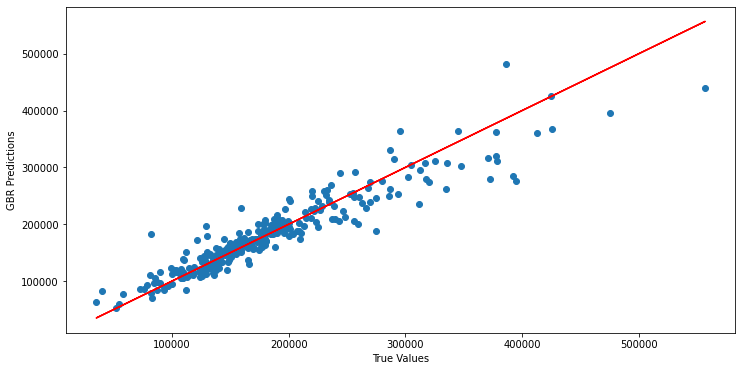

In [16]:
plt.figure(figsize=(12,6))
predictions = BestGBR.fit(X_train_scaled, y_train).predict(X_validate_scaled)
plt.scatter(y_validate, predictions)
plt.xlabel('True Values')
plt.ylabel('GBR Predictions')
plt.plot(y_validate, y_validate, 'r')
plt.show()


##Importance of the features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

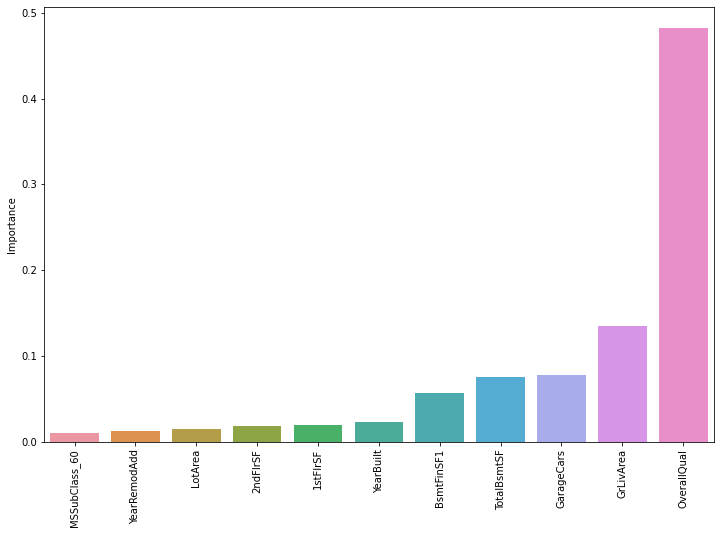

In [17]:
feature_import = BestGBR.feature_importances_
imp_feat = pd.DataFrame(index=X_train.columns,
                        data=feature_import,
                        columns=['Importance'])
imp_feat = imp_feat[imp_feat['Importance'] > 0.01]
imp_feat = imp_feat.sort_values('Importance')
plt.figure(figsize=(12,8))
sns.barplot(data=imp_feat,
            x=imp_feat.index,
            y='Importance')
plt.xticks(rotation=90)


In [18]:
imp_feat.index


Index(['MSSubClass_60', 'YearRemodAdd', 'LotArea', '2ndFlrSF', '1stFlrSF',
       'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageCars', 'GrLivArea',
       'OverallQual'],
      dtype='object')

#Extreme Boosting Regressor

##Optimization of parameters

In [ ]:
xGBR = XGBRegressor()
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0], 'n_estimators': [100, 200, 500], 'min_samples_leaf':[3], 'max_depth' : [4,6,8, 16,32]}

Grid10 = GridSearchCV(xGBR, param_grid, cv=5, n_jobs=4)
Grid10.fit(X_train_scaled, y_train)
BestxGBR = Grid10.best_estimator_

BestxGBR


##Explained variance by the model

In [ ]:
BestxGBR.fit(X_train_scaled, y_train)
BestxGBR_rmse = mean_squared_error(y_train, BestxGBR.predict(X_train_scaled))
print(f"xGBR RMSE:{BestxGBR_rmse:.3f}")
BestxGBR_mabser = mean_absolute_error(y_train, BestxGBR.predict(X_train_scaled))
print(f"xGBR RMSE:{BestxGBR_mabser:.3f}")
Best_xGBR_r2 = metrics.r2_score(y_train, BestxGBR.predict(X_train_scaled))
print(f"xGBR R2:{Best_xGBR_r2:.3f}")


###Cross Validation - cross_validate

In [ ]:
scores_xGBR = sklearn.model_selection.cross_validate(BestxGBR, X_train_scaled, y_train,
                                                scoring=['r2','neg_mean_squared_error','neg_mean_absolute_error'], cv=10)	

scores_xGBR = pd.DataFrame(scores_xGBR)


In [31]:
scores_xGBR


,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,1.996404,0.006486,0.909799,-3.551196e+08,-13448.479634
1,1.860167,0.006003,0.922396,-4.288846e+08,-14558.452925
2,2.077653,0.004476,0.944128,-5.329068e+08,-15647.922242
3,1.110982,0.004051,0.914841,-6.587528e+08,-14917.951890
4,1.113936,0.004464,0.901511,-6.871889e+08,-16760.718149
5,1.112450,0.004331,0.859853,-7.114923e+08,-17244.951239
6,1.131404,0.004153,0.929070,-4.452428e+08,-14811.527748
7,1.116259,0.004171,0.940770,-4.551730e+08,-15957.207099
8,1.114733,0.004162,0.917358,-4.500386e+08,-14452.819100
9,1.109644,0.003959,0.933900,-3.640433e+08,-13566.745420


In [32]:
scores_xGBR.describe().T


,count,mean,std,min,25%,50%,75%,max
fit_time,10.0,1.374363e+00,4.198516e-01,1.109644e+00,1.112822e+00,1.115496e+00,1.677976e+00,2.077653e+00
score_time,10.0,4.625559e-03,8.764742e-04,3.958941e-03,4.155278e-03,4.250884e-03,4.473031e-03,6.486177e-03
test_r2,10.0,9.173627e-01,2.431804e-02,8.598533e-01,9.110596e-01,9.198773e-01,9.326925e-01,9.441279e-01
test_neg_mean_squared_error,10.0,-5.088843e+08,1.322038e+08,-7.114923e+08,-6.272913e+08,-4.526058e+08,-4.329742e+08,-3.551196e+08
test_neg_mean_absolute_error,10.0,-1.513668e+04,1.259949e+03,-1.724495e+04,-1.587989e+04,-1.486474e+04,-1.447923e+04,-1.344848e+04


##Model predictions

###Cross Validation - Train Test Split

In [24]:
BestxGBR_rmse_val = mean_squared_error(y_validate, BestxGBR.predict(X_validate_scaled))
print(f"xGBR RMSE_VAL:{BestxGBR_rmse_val:.3f}")
BestxGBR_mabser_val = mean_absolute_error(y_validate, BestxGBR.predict(X_validate_scaled))
print(f"xGBR RMSE_VAL:{BestxGBR_mabser_val:.3f}")
Best_xGBR_r2_val = metrics.r2_score(y_validate, BestxGBR.predict(X_validate_scaled))
print(f"xGBR R2_VAL:{Best_xGBR_r2_val:.3f}")


xGBR RMSE_VAL:563152952.202
xGBR RMSE_VAL:15902.238
xGBR R2_VAL:0.906


[15:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


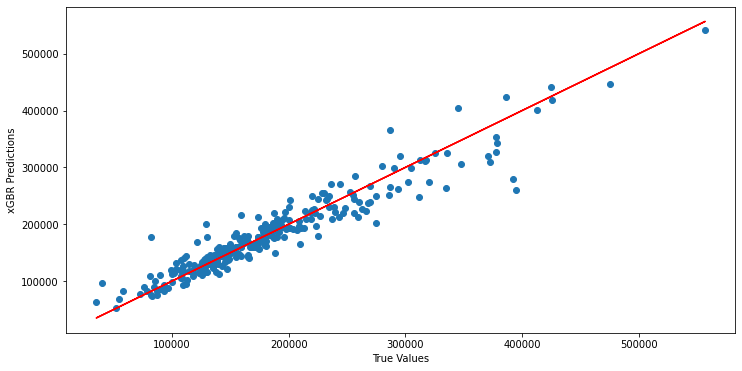

In [25]:
plt.figure(figsize=(12,6))
predictions = BestxGBR.fit(X_train_scaled, y_train).predict(X_validate_scaled)
plt.scatter(y_validate, predictions)
plt.xlabel('True Values')
plt.ylabel('xGBR Predictions')
plt.plot(y_validate, y_validate, 'r')


##Importance of the features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

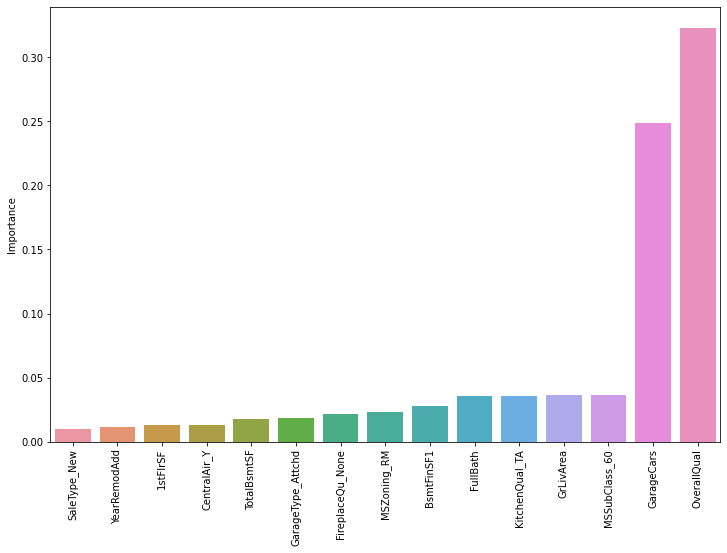

In [26]:
feature_import = BestxGBR.feature_importances_
imp_feat = pd.DataFrame(index=X_train.columns,
                        data=feature_import,
                        columns=['Importance'])
imp_feat = imp_feat[imp_feat['Importance'] > 0.01]
imp_feat = imp_feat.sort_values('Importance')
plt.figure(figsize=(12,8))
sns.barplot(data=imp_feat,
            x=imp_feat.index,
            y='Importance')
plt.xticks(rotation=90)


#Conclusion

xGBR gave better results then the GBR model.
Both gradient boosting regressors are giving good fit to this model and are explaining about the 90% of the variance of the data.